# fct_monthly_schedule_rt_route_direction_summary
* schedule stats (headway, freq, n_trips) by route-direction
* operator summary charts
* [Tiffany's explanation](https://github.com/cal-itp/data-analyses/issues/1752#issuecomment-3563818122)

In [1]:
import datetime
import sys

import _sql_query
import google.auth
import pandas as pd
from google.cloud import bigquery
from loguru import logger
from shared_utils import rt_dates
from update_vars import SEGMENT_GCS

credentials, project = google.auth.default()

import _operator_grain_route_dir_visuals as _report_operator_visuals
import _portfolio_charts
import altair as alt
from IPython.display import HTML, Image, Markdown, display, display_html
from omegaconf import OmegaConf
from shared_utils import catalog_utils, gtfs_utils_v2, portfolio_utils, publish_utils
from update_vars import GTFS_DATA_DICT, RT_SCHED_GCS

readable_dict = OmegaConf.load("new_readable.yml")

In [2]:
pd.options.display.max_columns = 100
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

In [3]:
GTFS_DATA_DICT = catalog_utils.get_catalog("gtfs_analytics_data")

In [4]:
# rt_dates.DATES

In [5]:
analysis_name = "City and County of San Francisco"

In [6]:
def formatted(number):
    return "{:,}".format(number)

In [7]:
url = "gs://calitp-analytics-data/data-analyses/gtfs_digest/processed/schedule_rt_route_direction_summary_2026_01.parquet"

In [8]:
df = pd.read_parquet(url)

_request non-retriable exception: ('Error code invalid_grant: Refresh token has expired', '{"error":"invalid_grant","error_description":"Refresh token has expired"}')
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/gcsfs/retry.py", line 135, in retry_request
    return await func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/gcsfs/core.py", line 467, in _request
    headers=self._get_headers(headers),
            ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/gcsfs/core.py", line 444, in _get_headers
    self.credentials.apply(out)
  File "/opt/conda/lib/python3.11/site-packages/gcsfs/credentials.py", line 223, in apply
    self.maybe_refresh()
  File "/opt/conda/lib/python3.11/site-packages/gcsfs/credentials.py", line 211, in maybe_refresh
    self.credentials.refresh(req)
  File "/opt/conda/lib/python3.11/site-packages/google/auth/external_account_authorized_user.p

OAuthError: ('Error code invalid_grant: Refresh token has expired', '{"error":"invalid_grant","error_description":"Refresh token has expired"}')

In [ ]:
df.head(2).drop(columns = ['Frequency All Day', "Frequency Offpeak", "Frequency Peak"])

In [ ]:
# df.Name.unique()

### Route Typology

In [ ]:
def pie_chart(
    df: pd.DataFrame, color_col: str, theta_col: str, color_scheme: list, tooltip_cols:list
) -> alt.Chart:
    chart = (
        alt.Chart(df)
        .mark_arc()
        .encode(
            theta=theta_col,
            color=alt.Color(
                color_col,
                title=(color_col),
                scale=alt.Scale(range=color_scheme),
            ),
            tooltip=tooltip_cols,
        )
    )

    return chart

In [ ]:
def create_typology(df:pd.DataFrame)->pd.DataFrame:
    df2 = df.groupby(['Route Typology']).agg({"Route":"nunique"}).reset_index()
    df2 = df2.rename(columns = {"Route":"Total Routes"})
    return df2

In [ ]:
typology = create_typology(df)

In [ ]:
typology

In [ ]:
pie_chart(df = typology,
         color_col = 'Route Typology',
         theta_col = 'Total Routes',
         color_scheme = ["#5b8efd", "#765fec", "#fcb40e", "#fc5c04", "#dd217d", "#ccbb44", "#c5c5c4"],
         tooltip_cols = list(typology.columns))

In [ ]:
def create_route_typology(df: pd.DataFrame):
    typology_df = create_typology(df)
    chart_dict = readable_dict.route_typology

    chart = pie_chart(df = typology_df,
         color_col = 'Route Typology',
         theta_col = 'Total Routes',
         color_scheme = [*chart_dict.colors],
         tooltip_cols = list(chart_dict.tooltip))
    
    chart = (
        _portfolio_charts.configure_chart(
            chart,
            width=200,
            height=250,
            title=chart_dict.title,
            subtitle="",
        )
    )
    return chart

### Operator Grain: Scheduled Minutes

In [ ]:
def create_route_dropdown(df: pd.DataFrame):
    routes_list = df["Route"].unique().tolist()
    route_dropdown = alt.binding_select(
        options=routes_list,
        name="Routes: ",
    )

    # Column that controls the bar charts
    xcol_param = alt.selection_point(
        fields=["Route"], value=routes_list[0], bind=route_dropdown
    )
    return xcol_param

In [ ]:
def create_scheduled_minutes(df: pd.DataFrame):
    df2 = df.loc[df["Day Type"] == "Weekday"]
    chart_dict = readable_dict.avg_scheduled_minutes

    xcol_param = create_route_dropdown(df)

    dir_0_chart = _portfolio_charts.bar_chart(
        df=df2.loc[df2.Direction == 0],
        x_col="Date",
        y_col="Average Scheduled Minutes",
        color_col="Direction",
        color_scheme=[*chart_dict.colors],
        tooltip_cols=list(chart_dict.tooltip),
        date_format="",
        y_ticks=chart_dict.ticks,
    )

    dir_0_chart = (
        _portfolio_charts.configure_chart(
            dir_0_chart,
            width=200,
            height=250,
            title=f"{chart_dict.title} for Direction 0",
            subtitle=chart_dict.subtitle,
        )
        .add_params(xcol_param)
        .transform_filter(xcol_param)
    )

    dir_1_chart = _portfolio_charts.bar_chart(
        df=df2.loc[df2.Direction == 1],
        x_col="Date",
        y_col="Average Scheduled Minutes",
        color_col="Direction",
        color_scheme=[*chart_dict.colors],
        tooltip_cols=list(chart_dict.tooltip),
        date_format="",
        y_ticks=chart_dict.ticks,
    )
    dir_1_chart = (
        _portfolio_charts.configure_chart(
            dir_1_chart,
            width=200,
            height=250,
            title="Direction 1",
            subtitle="",
        )
        .add_params(xcol_param)
        .transform_filter(xcol_param)
    )
    chart = alt.hconcat(dir_0_chart, dir_1_chart)
    return chart

In [ ]:
create_scheduled_minutes(subset_df)

### Operator: Total Scheduled Trips for Vehicles Going Direction X
* Use `daily_trips_all_day`

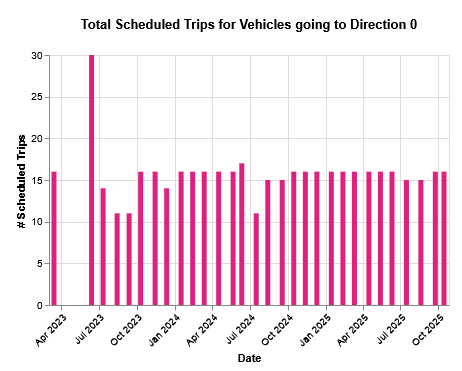

In [ ]:
def create_scheduled_trips(df: pd.DataFrame):
    df2 = df.loc[df["Day Type"] == "Weekday"]
    chart_dict = readable_dict.scheduled

    xcol_param = create_route_dropdown(df)

    dir_0_chart = _portfolio_charts.bar_chart(
        df=df2.loc[df2.Direction == 0],
        x_col="Date",
        y_col="Daily Trips All Day",
        color_col="Direction",
        color_scheme=[*chart_dict.colors],
        tooltip_cols=list(chart_dict.tooltip),
        date_format="",
        y_ticks=chart_dict.ticks,
    )

    dir_0_chart = (
        _portfolio_charts.configure_chart(
            dir_0_chart,
            width=200,
            height=250,
            title=f"{chart_dict.title} for Direction 0",
            subtitle=chart_dict.subtitle,
        )
        .add_params(xcol_param)
        .transform_filter(xcol_param)
    )

    dir_1_chart = _portfolio_charts.bar_chart(
        df=df2.loc[df2.Direction == 1],
        x_col="Date",
        y_col="Daily Trips All Day",
        color_col="Direction",
        color_scheme=[*chart_dict.colors],
        tooltip_cols=list(chart_dict.tooltip),
        date_format="",
        y_ticks=chart_dict.ticks,
    )
    dir_1_chart = (
        _portfolio_charts.configure_chart(
            dir_1_chart,
            width=200,
            height=250,
            title="Direction 1",
            subtitle="",
        )
        .add_params(xcol_param)
        .transform_filter(xcol_param)
    )
    chart = alt.hconcat(dir_0_chart, dir_1_chart)
    return chart

In [ ]:
create_scheduled_trips(subset_df)

### Frequency of Trips Peak/Off Peak for Direction X
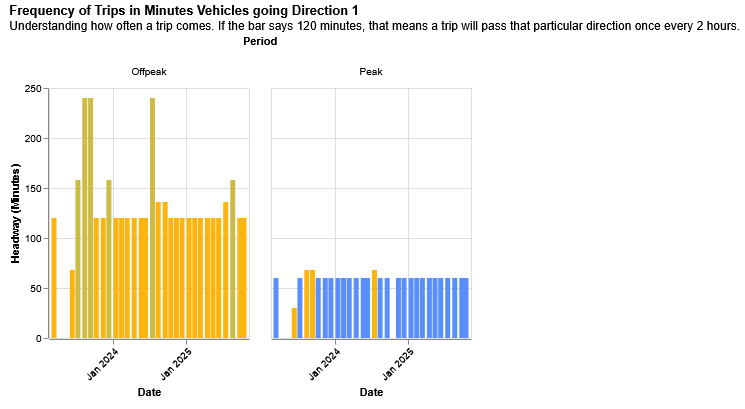

In [ ]:
def create_frequency(df: pd.DataFrame):
    df2 = df.loc[df["Day Type"] == "Weekday"]
    chart_dict = readable_dict.frequency

    xcol_param = create_route_dropdown(df)

    dir_0_chart = _portfolio_charts.bar_chart(
        df=df2.loc[df2.Direction == 0],
        x_col="Date",
        y_col="Headway All Day",
        color_col="Direction",
        color_scheme=[*chart_dict.colors],
        tooltip_cols=list(chart_dict.tooltip),
        date_format="",
        y_ticks=chart_dict.ticks,
    )

    dir_0_chart = (
        _portfolio_charts.configure_chart(
            dir_0_chart,
            width=200,
            height=250,
            title=f"{chart_dict.title} for Direction 0",
            subtitle=chart_dict.subtitle,
        )
        .add_params(xcol_param)
        .transform_filter(xcol_param)
    )

    dir_1_chart = _portfolio_charts.bar_chart(
        df=df2.loc[df2.Direction == 1],
        x_col="Date",
        y_col="Headway All Day",
        color_col="Direction",
        color_scheme=[*chart_dict.colors],
        tooltip_cols=list(chart_dict.tooltip),
        date_format="",
        y_ticks=chart_dict.ticks,
    )
    dir_1_chart = (
        _portfolio_charts.configure_chart(
            dir_1_chart,
            width=200,
            height=250,
            title="Direction 1",
            subtitle="",
        )
        .add_params(xcol_param)
        .transform_filter(xcol_param)
    )
    chart = alt.hconcat(dir_0_chart, dir_1_chart)
    return chart

In [ ]:
create_frequency(subset_df)

#### Statewide Metric

### Text Table

In [ ]:
def create_text_table(df: pd.DataFrame) -> pd.DataFrame:
    most_recent_date = df["Date"].max()
    most_recent_df = df.loc[
        (df.Date == most_recent_date) & (df["Day Type"] == "Weekday")
    ]
    text_table_df = most_recent_df.melt(
        id_vars=[
            "Date",
            "Route",
            "Direction",
        ],
        value_vars=[
            "Average Scheduled Minutes",
            "Average Scheduled Minutes",
            "Daily Trips All Day",
            "Headway All Day",
            "Headway Peak",
            "Headway Offpeak",
        ],
    ).sort_values(by=["Route", "Direction"])

    text_table_df.value = text_table_df.value.fillna(0)
    text_table_df.value = text_table_df.value.round(2)
    # text_table_df.value = text_table_df.value.astype(int)
    text_table_df.value = text_table_df.value.astype(str)
    text_table_df.value = text_table_df.value.replace("0", "N/A")

    text_table_df["Zero"] = 0

    text_table_df["combo_col"] = (
        text_table_df.variable.astype(str) + ": " + text_table_df.value.astype(str)
    )
    text_table_df["Direction"] = text_table_df.Direction.astype(str)

    return text_table_df

In [ ]:
df2 = create_text_table(subset_df)

In [ ]:
df2.info()

In [ ]:
df2.sample(3)

In [ ]:
def text_table(df: pd.DataFrame) -> alt.Chart:

    # Create the chart
    text_chart = (
        alt.Chart(df)
        .mark_text()
        .encode(x=alt.X("Zero:Q", axis=None), y=alt.Y("combo_col", axis=None))
    )

    text_chart = text_chart.encode(text="combo_col:N")

    return text_chart

In [ ]:
def create_text_graph(df: pd.DataFrame):
    chart_dict = readable_dict.avg_scheduled_minutes
    
    df2 = create_text_table(df)

    # Create dropdown menus
    options = ["0", "1"]
    input_dropdown = alt.binding_radio(
        # Add the empty selection which shows all when clicked
        options=options,
        labels=options,
        name="Direction: ",
    )
    selection = alt.selection_point(
        fields=["Direction"],
        value=options[0],
        bind=input_dropdown,
    )

    xcol_param = create_route_dropdown(df2)

    chart = (
        (
            _report_operator_visuals.configure_chart(
                text_table(df2),
                width=400,
                height=250,
                title=chart_dict.title,
                subtitle=chart_dict.subtitle,
            )
        )
        .add_params(xcol_param)
        .transform_filter(xcol_param)
        .add_params(selection)
        .transform_filter(selection)
    )

    return chart

In [ ]:
create_text_graph(subset_df)